In [50]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from mappymatch.constructs.trace import Trace
from mappymatch.maps.nx.nx_map import NxMap
from mappymatch.maps.nx.readers.osm_readers import parse_osmnx_graph, NetworkType
from mappymatch.matchers.lcss.lcss import LCSSMatcher

import utils

In [51]:
dataset_path = "../datasets/UrbanVehicle"

road_graph_ox_og = ox.graph_from_bbox(bbox=(113.95088, 22.57502, 114.08323, 22.71175), network_type="drive",
                                      simplify=False)

road_graph_ox = ox.add_edge_speeds(road_graph_ox_og)
road_graph_ox = ox.add_edge_travel_times(road_graph_ox)

road_graph_ox = ox.project_graph(road_graph_ox, to_crs=utils.EPSG_32650)

# fig, ax = ox.plot_graph(
#     road_graph_ox,
#     figsize=(10, 10),
#     node_size=10,
#     show=True,
# )
# fig.savefig(f"{dataset_path}/road_graph_ox.svg", format="svg")
# print(road_graph_ox)

road_graph_ox = ox.simplify_graph(road_graph_ox, track_merged=True)

# fig, ax = ox.plot_graph(
#     road_graph_ox,
#     figsize=(10, 10),
#     node_size=10,
#     show=True,
# )
# fig.savefig(f"{dataset_path}/road_graph_ox_sim.svg", format="svg")
# print(road_graph_ox)

road_graph_ox = ox.consolidate_intersections(road_graph_ox, tolerance=35, rebuild_graph=True, dead_ends=True,
                                             reconnect_edges=True)

# fig, ax = ox.plot_graph(
#     road_graph_ox,
#     figsize=(10, 10),
#     node_size=10,
#     show=True,
# )
# fig.savefig(f"{dataset_path}/road_graph_ox_sim_con.svg", format="svg")
# print(road_graph_ox)

road_graph_ox = ox.project_graph(road_graph_ox, to_crs=utils.EPSG_4326)

sccs = nx.strongly_connected_components(road_graph_ox)
max_scc = max(sccs, key=len)
road_graph_ox = road_graph_ox.subgraph(max_scc).copy()

In [52]:
map = NxMap(parse_osmnx_graph(road_graph_ox, network_type=NetworkType.DRIVE))

dataset_path = "../datasets/UrbanVehicle"
trajectories = list()
with open(f"{dataset_path}/trajectories.json", mode="r", encoding="utf-8") as file:
    for line in file:
        trajectory = json.loads(line)
        trajectory["xyt"].sort(key=lambda l: l[2])
        trace = list()
        for x, y, _ in trajectory["xyt"]:
            gps_points = utils.xy_to_epsg4326(np.array([[x, y]]))
            lon = gps_points[0, 0]
            lat = gps_points[0, 1]
            trace.append([lon, lat])
        trace = pd.DataFrame(trace, columns=["longitude", "latitude"])
        trajectories.append({"vehicle_id": trajectory["vehicle_id"], "trace": trace})

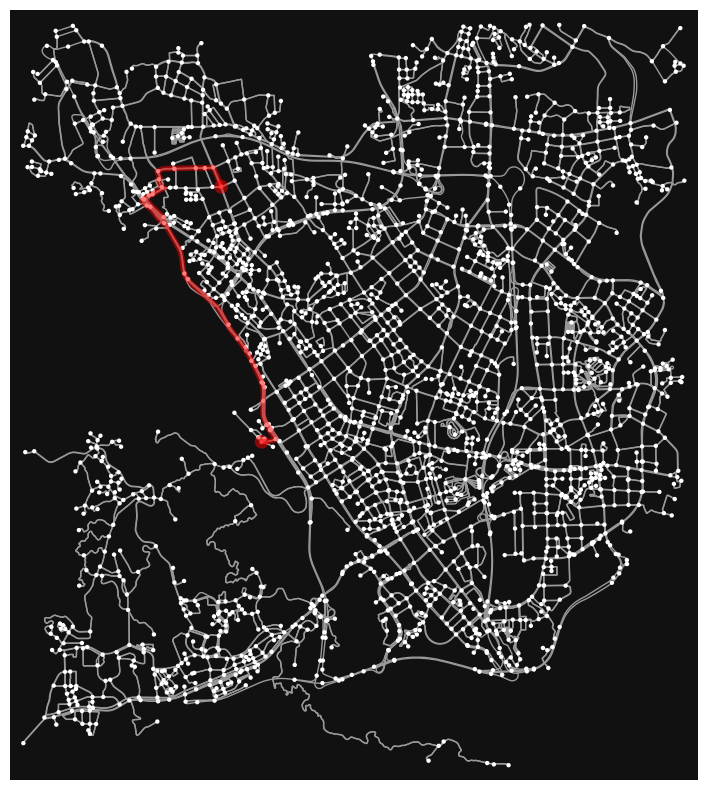

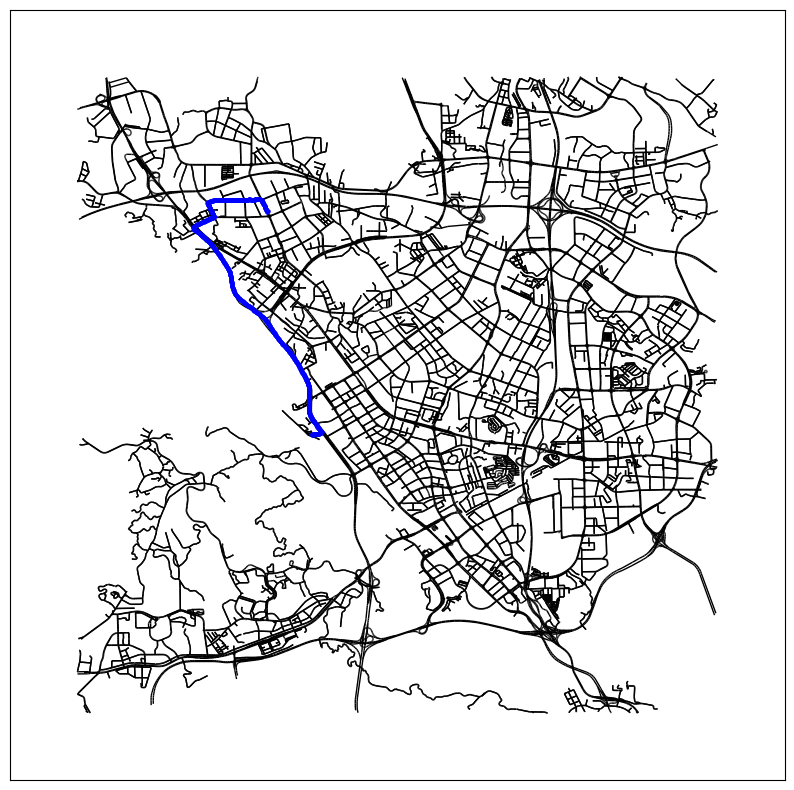

In [53]:
index = 0
trajectory = trajectories[index]["trace"]

trace = Trace.from_dataframe(trajectory, lon_column="longitude", lat_column="latitude")
matcher = LCSSMatcher(map)
match_result = matcher.match_trace(trace)

path_df = match_result.path_to_dataframe()
path = list()
for _, (u, v, _) in path_df[["origin_junction_id", "destination_junction_id", "road_key"]].iterrows():
    path.append(u)
path.append(v)

fig, ax = ox.plot_graph_route(
    road_graph_ox,
    path,
    figsize=(10, 10),
    node_size=10,
    show=True
)

pos = {node: (road_graph_ox_og.nodes[node]["x"], road_graph_ox_og.nodes[node]["y"]) for node in
       road_graph_ox_og.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    road_graph_ox_og,
    pos,
    arrows=False,
    ax=ax
)

trajectory = np.array(trajectory)
ax.scatter(trajectory[:, 0], trajectory[:, 1], s=5, c="blue")

plt.show()